In [2]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
import numpy as np
%matplotlib inline

df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    df = pd.concat([df, df_csv])
    

label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        label_names.append(row[1])

del label_names[0]
        
print (label_names)


['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


In [3]:
## THIS IS FOR TEST

class_id_set = [5,10,12,15,19,24,28,36]
tdf = pd.DataFrame()
t_label_names = []

for i, class_id in enumerate(class_id_set):
    print (i, class_id)
    selected = df[df['ClassId'] == class_id]
    selected['ClassId'] = i
    tdf = pd.concat((tdf, selected))
    t_label_names.append(label_names[class_id])

print (t_label_names)
print (len(tdf))


label_names = t_label_names
df = tdf

0 5
1 10
2 12
3 15


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4 19
5 24
6 28
7 36
['Speed limit (80km/h)', 'No passing for vehicles over 3.5 metric tons', 'Priority road', 'No vehicles', 'Dangerous curve to the left', 'Road narrows on the right', 'Children crossing', 'Go straight or right']
8010


8010
8010
Filename                       00045_00015.ppm
Width                                       39
Height                                      36
Roi.X1                                       6
Roi.Y1                                       5
Roi.X2                                      33
Roi.Y2                                      30
ClassId                                      0
Path        GTSRB/Final_Training/Images/00005/
Name: 1365, dtype: object
Speed limit (80km/h)


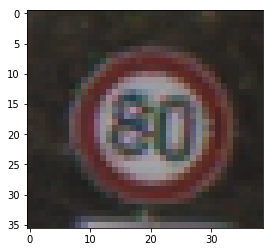

In [4]:
# shuffling the samples
print (len(df))
df = df.sample(frac=1)
print (len(df))

n = 6000
print (df.iloc[n])
print (label_names[df.iloc[n]['ClassId']])
img = misc.imread(df.iloc[n]['Path'] + df.iloc[n]['Filename'])
plt.imshow(img)


In [5]:
from math import *
TEST_PROP = 0.2

train_set = df.iloc[0: floor(len(df)*(1-TEST_PROP))]
test_set = df.iloc[floor(len(df) * (1-TEST_PROP)):]

print ('Count of train set: ', len(train_set))
print ('Count of test set: ', len(test_set))


Count of train set:  6408
Count of test set:  1602


0 1495
1 1635
2 1668
3 515
4 173
5 200
6 423
7 299


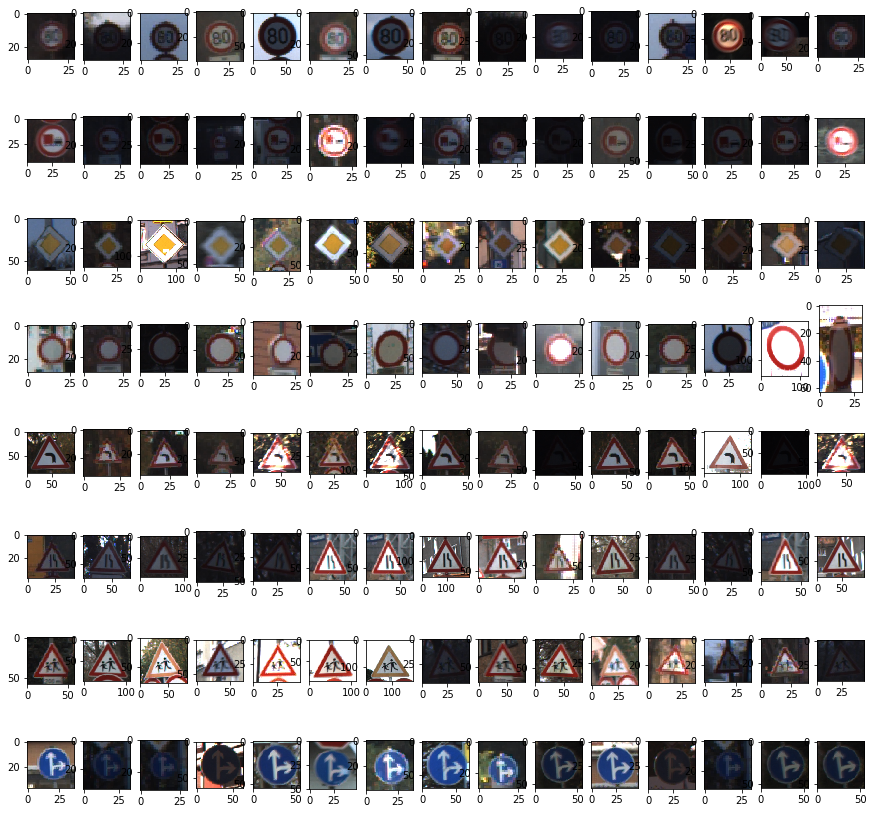

In [6]:
n = 8
c = 15
plt.figure(figsize=(15,15))
#for i in range(len(label_names)):
for i in range(n):
    selected = train_set.loc[train_set['ClassId'] == i]
    print (i, len(selected))
    for j in range(c):
        plt.subplot(n, c, (i*c) + j+1 )
        plt.imshow(misc.imread(selected.iloc[j]['Path'] + selected.iloc[j]['Filename']))

In [7]:
from sklearn import preprocessing
from skimage import exposure

NORM_W = 32
NORM_H = 32
# the generator
def generator(df, batch_size=100):
    
    while 1:
        df = df.sample(frac=1)
        X, Y = [], []
        for i in range(batch_size):
            img = misc.imresize(misc.imread(df.iloc[i]['Path'] + df.iloc[i]['Filename']), (NORM_W, NORM_H))
            img = exposure.equalize_hist(img)
            X.append(img)
            Y.append(df.iloc[i]['ClassId'])
       
        enc = preprocessing.LabelBinarizer()
        enc.fit(range(len(label_names)))

        yield np.float32(X), np.array(enc.transform(Y))
        

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


1.0 0.000325521
1.0 0.000325521
1.0 0.000325521
1.0 0.0094401
1.0 0.000976562
1.0 0.000651042
1.0 0.000651042
1.0 0.00651042
1.0 0.00748698
1.0 0.000325521
1.0 0.000325521
1.0 0.00227865
1.0 0.000325521
1.0 0.00520833
1.0 0.000651042
1.0 0.000325521
1.0 0.00130208
1.0 0.0016276
1.0 0.000325521
1.0 0.000325521


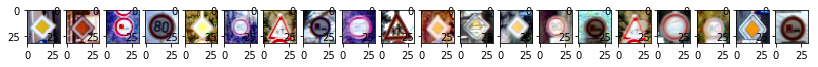

In [8]:
n = 20
test_g = generator(train_set, batch_size = n)

X, Y = next(test_g)

plt.figure(figsize=(14,10))
for x in range(n):
    plt.subplot(1, n, x+1)
    plt.imshow(X[x])
    print(np.max(X[x]), np.min(X[x]))

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
import tensorflow as tf


def reduce_palette(x):
    n = 4
    return tf.ceil((x/n) * n)

model = Sequential()
#model.add(Lambda(reduce_palette, input_shape = (32, 32, 3)))

model.add(Convolution2D(32,3,3, input_shape = (32, 32, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(128,3,3,))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(len(label_names)))

print (model.output)


Using TensorFlow backend.


Tensor("add_5:0", shape=(?, 8), dtype=float32)


In [10]:
gen = generator(train_set, batch_size=300)
val_gen = generator(train_set, batch_size=300)


model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch=3000, nb_epoch=10, validation_data=val_gen, nb_val_samples=300)



Epoch 1/10


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


3000/3000 [==============================] - 7s - loss: 0.2850 - acc: 0.1803 - val_loss: 0.1210 - val_acc: 0.2567
Epoch 2/10
3000/3000 [==============================] - 6s - loss: 0.1103 - acc: 0.2330 - val_loss: 0.0983 - val_acc: 0.2333

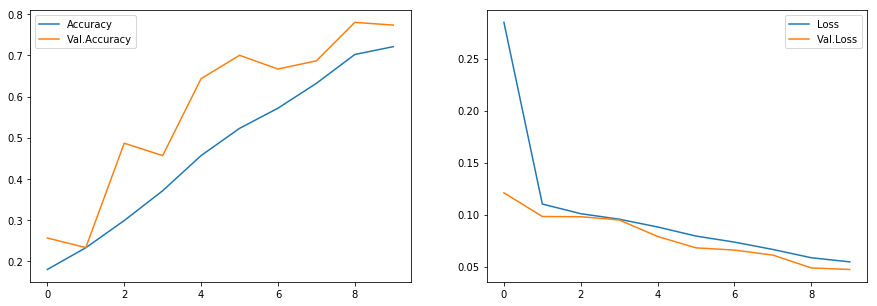

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Val.Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend()

In [13]:
# test

TEST_SIZE = 1000
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

pr_get = generator(test_set, batch_size=TEST_SIZE)
X, Y = next(pr_get)

pr = model.predict(X)

pred_labels = np.argmax(pr, axis=1)
truth = np.argmax(Y, axis=1)

print (pr[1])

match_ratio = sum(pred_labels == truth)
print ('Matches: {} of {}; {} %'.format( match_ratio, TEST_SIZE, match_ratio / TEST_SIZE * 100) )


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


[ 0.30845368  0.26821876  0.12022574  0.12199203 -0.0214177   0.0257073
  0.0284346   0.05481946]
Matches: 781 of 1000; 78.10000000000001 %
